# About this notebook

- pytorch
- data augmentation with Albumentations
- links for documentations
- convolutions
- learning curves plots
- predictions (~99% accuracy)

In the gif below it is shown how a convolution works. 

Convolution is the process of adding each element of the image to its local neighbors, weighted by the kernel.

The kernel (in yellow), also known as filter or detector, is a two-dimensional matrix that slides through the input image performing these calculations on the image's pixel values. This process extracts features and creates feature maps. The resulting matrix has the same dimensions as the kernel.

Here, the kernel navigates through the image by a step of 1. This step is called stride.

<img src="https://glassboxmedicine.files.wordpress.com/2019/07/convgif.gif?w=616" width="700px">

The image below shows the pooling process, used to down sample the created feature maps and summarize the presence of the detected features. It is useful to reduce computation time, but some information is also lost in the process. 

The example below shows a MaxPooling operation, which extracts the max value on the sub-region of the image in which the kernel size (2,2) is at.

<img src=https://austingwalters.com/wp-content/uploads/2019/01/max-pooling.png width="480px">

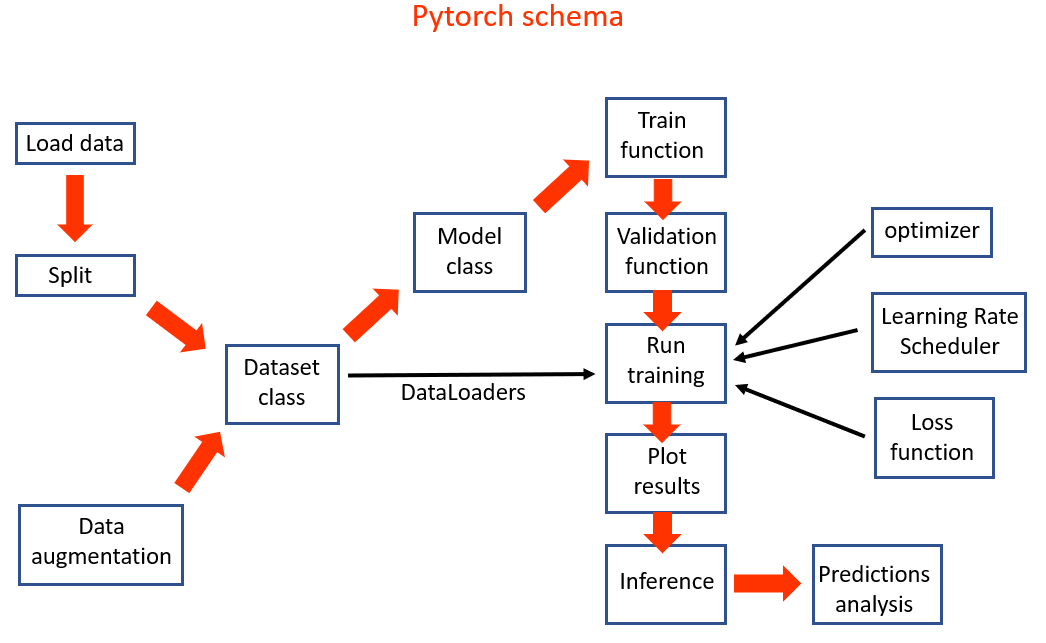

# Importing

In [ ]:
!pip install torchsummary -q

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import random # for torch seed
import os # for torch seed

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, AdamW, RMSprop # optmizers
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau # Learning rate schedulers
from torchsummary import summary # model summary

import albumentations as A
# from albumentations.pytorch import ToTensorV2

In [ ]:
# Load the data
INPUT_PATH = '../input/digit-recognizer/'
OUTPUT_PATH = './'

train = pd.read_csv(INPUT_PATH + "train.csv")
test = pd.read_csv(INPUT_PATH + "test.csv")

In [ ]:
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

print("\nTrain dataset:")
display(train)
print("\nTest dataset:")
display(test)

In [ ]:
# check missing values
print("Missing values in train dataset: ", train.isnull().any().sum())
print("Missing values in test dataset: ", test.isnull().any().sum())

# CFG

This class enables easy configuration to simulate and understand results.

You can tweak some parameters and see how they impact on the metrics, plots, and predictions.

In [ ]:
class CFG:
  DEBUG = False

  ### input: not configurable
  IMG_HEIGHT = 28
  IMG_WIDTH = 28
  N_CLASS = len(np.unique(train['label']))

  ### split train and validation sets
  split_fraction = 0.95

  ### training
  print_freq = 100
  BATCH_SIZE = 1024
  N_EPOCHS = 30

  ### set only one to True
  save_best_loss = False
  save_best_accuracy = True

  ### optimizer
  # optimizer = 'adam'
  # optimizer = 'adamw'
  optimizer = 'rmsprop'
  LEARNING_RATE = 1e-3
  weight_decay = 0.1 # for adamw
  l2_penalty = 0.01 # for RMSprop
  rms_momentum = 0 # for RMSprop

  ### learning rate scheduler (LRS)
  scheduler = 'ReduceLROnPlateau'
  # scheduler = 'CosineAnnealingLR'
  plateau_factor = 0.5
  plateau_patience = 3
  cosine_T_max = 4
  cosine_eta_min = 1e-8
  verbose = True

  ### train and validation DataLoaders
  shuffle = False

  ### albumentations
  probability = 0.6

  random_seed = 42

In [ ]:
if CFG.DEBUG:
  CFG.N_EPOCHS = 10
  train = train.sample(frac = 0.5).reset_index(drop=True) # n = 10_000
  CFG.N_CLASS = len(np.unique(train['label']))

In [ ]:
print("DEBUG?: ", CFG.DEBUG)
print("Train shape: ", train.shape)
print("Test shape: ", test.shape)

print(f"\nImage shape (H, W): ({CFG.IMG_HEIGHT},{CFG.IMG_WIDTH})")
print("Number of classes in train dataset: ", CFG.N_CLASS)

In [ ]:
# detect and define device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

In [ ]:
# for reproducibility
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed = CFG.random_seed)

In [ ]:
# class distribution
train['label'].hist(bins = CFG.N_CLASS);

# Split

In [ ]:
print('Before split:')
print('train shape: ', train.shape)

### simple split
# split = int(CFG.split_fraction * len(train))
# valid_df = train[split:].reset_index(drop = True)
# train_df = train[:split].reset_index(drop = True)

### random split
train_df, valid_df = train_test_split(train, test_size=(1-CFG.split_fraction), random_state=CFG.random_seed)

print('\nAfter split:')
print('train_df shape: ', train_df.shape)
print('valid_df shape: ', valid_df.shape)

# Dataset class

[torch Dataset and DataLoader documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)

A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. 

- The __init__ function is run once when instantiating the Dataset object. We initialize the variable X_col (features columns), and the variable y_col ('label' column).

- The __len__ function returns the number of samples in our dataset.

- The __getitem__ function returns a sample from the dataset at the given index idx. Based on the index, it retrieves the image’s features and label on the csv file and then converts that to a tensor.

When performing inference, we obviously don't have the label values.

The Dataset class retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, and DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [ ]:
### for training and validation
class DigitDataset(Dataset):
    def __init__(self, df, X_col, y_col, augmentations = None):
        self.features = df[X_col].values/255 # scale (greyscale) only features. do not scale target
        self.targets = df[y_col].values.reshape((-1, 1))
        self.augmentations = augmentations 

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        image = self.features[idx].reshape((1, 28, 28))
        label = self.targets[idx]

        if self.augmentations is not None:
          augmented = self.augmentations(image=image)   
          return torch.FloatTensor(augmented['image']), torch.FloatTensor(label)
        else:
          return torch.FloatTensor(image), torch.FloatTensor(label)


### for inference
class DigitInferenceDataset(Dataset):
    def __init__(self, df, augmentations = None): # for inference we only have the features dataframe
        self.features = df.values/255 # scale (greyscale) features
        self.augmentations = augmentations 

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        image = self.features[idx].reshape((1, 28, 28))
        return torch.FloatTensor(image)

# Data Augmentation

Set parameter p (probability of applying the transformation) to 1 to make sure you will visualize the augmentations.

[Albumentations Demo](https://albumentations-demo.herokuapp.com/)

[Albumentations docs](https://albumentations.ai/docs/getting_started/transforms_and_targets/)

[Albumentations transforms](https://albumentations.ai/docs/getting_started/transforms_and_targets/)

In [ ]:
transform_train = A.Compose([
                  # A.Resize(CFG.IMG_HEIGHT - 20, CFG.IMG_WIDTH - 20, p=CFG.probability),
                  # A.HorizontalFlip(p=CFG.probability), # 0.2
                  # A.VerticalFlip(p=CFG.probability), # 0.5
                  # A.CenterCrop(23, 23, p=CFG.probability),
                  # A.RandomCrop(width=23, height=23, p=CFG.probability),                  
                  # A.MotionBlur(p=CFG.probability), # 0.2
                  # A.Normalize(p=CFG.probability)                  
                  # A.Affine(p=CFG.probability),                  
                  # A.Equalize(p=CFG.probability),                  
                  # A.CLAHE(p=CFG.probability),                  
                  # ToTensorV2(),


                  A.Rotate(limit=40, p=CFG.probability), 
                  A.ShiftScaleRotate(rotate_limit=40, p=CFG.probability),
                  # A.IAASharpen(p=CFG.probability),
                  A.Downscale(scale_min=0.7, scale_max=0.7, p=CFG.probability)
])


transform_valid = A.Compose([
                  # A.Resize(CFG.IMG_HEIGHT, CFG.IMG_WIDTH, p=CFG.probability),
                  # ToTensorV2(),

])

In [ ]:
# check if Dataset class is working
# check some augmentations
y_col = "label"
X_col = [c for c in train.columns if c != 'label']

fig, ax = plt.subplots(5, 2, figsize = (6, 12))
fig.suptitle('Checking some augmentations', fontsize = 18)

# instantiate Dataset class
td = DigitDataset(train, X_col, y_col, augmentations = None) # no augmentation
td_aug = DigitDataset(train, X_col, y_col, augmentations = transform_train) # with data augmentation

# DataLoaders
tl = DataLoader(td, batch_size = CFG.BATCH_SIZE, shuffle = True) # no augmentation
tl_aug = DataLoader(td_aug, batch_size = CFG.BATCH_SIZE, shuffle = True) # with data augmentation

print('Length train_dataset (td): ', len(td))
print('Length train_dataloader (tl): ', len(tl))
print('Batch size: ', CFG.BATCH_SIZE)


# range to visualize augmented images
begin = 40
end = begin + 5

for i in range(begin, end):
  for j in range(0,1):
    # we can access and get data with index by __getitem__(index)
    img, lab = td.__getitem__(begin + i) # no augmentation
    img_aug, lab_aug = td_aug.__getitem__(begin + i) # with data augmentation

    # plot original image
    label = str(lab.item())
    ax[i - begin, j].set_title("Label: " + label, color="red") # write label in each image title
    ax[i - begin, j].imshow(np.squeeze(img), cmap='gray') # plot image
    ax[i - begin, j].axis('off')

    # plot augmented image
    ax[i - begin, j+1].set_title("Aug Label: " + label, color="red") # write label in each image title
    ax[i - begin, j+1].imshow(np.squeeze(img_aug), cmap='gray') # plot image
    ax[i - begin, j+1].axis('off')

# Model

[torch.nn documentation](https://pytorch.org/docs/stable/nn.html)

In [ ]:
class DigitModel(nn.Module):
    def __init__(self):
        super(DigitModel, self).__init__()
        
        # Convolution to detect features and create feature maps: kernel = feature detector = filter
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5,5), padding=0) # 128
        
        # activation
        self.actv = nn.LeakyReLU() # ReLU, LeakyReLU, PReLU, ELU, SELU, Tanh

        # Batch normalization 1
        self.batchnorm1 = nn.BatchNorm2d(32)
        
        # Max pool: down sample the detected features in feature maps
        self.maxpool = nn.MaxPool2d(kernel_size=(2,2)) # 2

        # Dropout
        self.dropout = nn.Dropout(0.25) 
     
        # Convolution
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), padding=0) # 64

        # Batch normalization 2
        self.batchnorm2 = nn.BatchNorm2d(64)        

        # flatten the feature map: reduce dimensionality
        self.flatten = nn.Flatten()

        # Fully connected
        self.fc1 = nn.Linear(64 * 4 * 4, 256)

        # Batch normalization 3
        self.batchnorm3 = nn.BatchNorm1d(256)  # 1 D because it is called after the flatten layer

        # The last fully connected layer must output the number of classes
        self.classifier = nn.Linear(256, CFG.N_CLASS)
    
    def forward(self, x):
        # conv1 block
        x = self.conv1(x)
        x = self.actv(x)
        x = self.batchnorm1(x)
        x = self.maxpool(x)
        # x = self.dropout(x) #  not using dropout because it is causing instability in validation curve 

        # conv2 block
        x = self.conv2(x)
        x = self.actv(x)
        x = self.batchnorm2(x)
        x = self.maxpool(x)
        # x = self.dropout(x) #  not using dropout because it is causing instability in validation curve 

        # flatten
        x = self.flatten(x)

        # print(x.size())
        
        # Linear functions
        x = self.fc1(x)
        x = self.batchnorm3(x)
#         x = self.dropout(x) #  not using dropout because it is causing instability in validation curve 
        out = self.classifier(x)
        
        return out 

# Optimizer

[torch optimizer documentation](https://pytorch.org/docs/stable/optim.html#)

Function to get the optimizer to be used (can be tuned in CFG class).

In [ ]:
def get_optimizer(lr = CFG.LEARNING_RATE):

  if CFG.optimizer == 'adam':
      optimizer = Adam(model.parameters(), lr=lr, weight_decay = CFG.weight_decay, amsgrad = False)

  elif CFG.optimizer == 'adamw':
    optimizer = AdamW(model.parameters(), lr = lr, weight_decay = CFG.weight_decay)

  elif CFG.optimizer == 'rmsprop':
    optimizer = RMSprop(model.parameters(), lr = lr, weight_decay = CFG.l2_penalty, momentum = CFG.rms_momentum)

  else:
    print('Optimizer is not defined')      

  return optimizer

In [ ]:
summary(DigitModel().cuda(), input_size=(1, 28, 28), batch_size = CFG.BATCH_SIZE)

# LR Scheduler

[torch LRS documentation](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)

Function to get the Learning Rate Scheduler to be used (can be tuned in CFG class).

torch.optim.lr_scheduler provides several methods to adjust the learning rate based on the number of epochs. 

torch.optim.lr_scheduler.ReduceLROnPlateau allows dynamic learning rate reducing based on some validation measurements.

Learning rate scheduling should be applied after optimizer’s update.

In [ ]:
def get_scheduler(optimizer):

  if CFG.scheduler=='ReduceLROnPlateau':
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor = CFG.plateau_factor, patience = CFG.plateau_patience, verbose = CFG.verbose)

  elif CFG.scheduler=='CosineAnnealingLR':
    scheduler = CosineAnnealingLR(optimizer, T_max = CFG.cosine_T_max, eta_min = CFG.cosine_eta_min)

  else:
    print('LR Scheduler is not defined')

  return scheduler 

# Train function

In [ ]:
def train_fn(train_loader, model, criterion, optmizer, device):

  size = len(train_loader.dataset)
  num_batches = len(train_loader)

  loss, correct = 0, 0

  ################################# train #################################

  # switch to train mode
  model.train()

  for batch, (X, y) in enumerate(train_loader):

    start = time.time()

    device = torch.device(device)
    X, y = X.to(device), y.to(device)  

    # compute predictions and loss
    optimizer.zero_grad()
    pred = model(X)
    loss = criterion(pred, y.long().squeeze()) 
    current = batch * len(X)

    # Backpropagation: only in train function, not done in validation function
    loss.backward()
    optimizer.step()

    # sum correct predictions
    y_pred, y_true = torch.argmax(pred, axis=1), y.long().squeeze()
    correct += (y_pred == y_true).type(torch.float).sum().item()

    end = time.time()
    time_delta = np.round(end - start, 3)

    # log
    loss, current = np.round(loss.item(), 5), batch * len(X)
    # if batch % (CFG.print_freq) == 0:
    #   print(f"Train Batch: {current:>5d}/{size:>5d}: loss: {loss:>5f} Elapsed Time: {time_delta} s")
  
  # metrics: calculate accuracy and loss for epoch (all batches)
  correct /= size # epoch accuracy
  loss /= num_batches # epoch loss

  print(f"Train: Accuracy: {(100*correct):>0.2f}%, Avg loss: {loss:>5f} \n")

  return loss, correct

# Validation function

[torch.no_grad documentation](https://pytorch.org/docs/stable/generated/torch.no_grad.html)

Use it when you are sure you will not call Tensor.backward(). It reduces memory and time consumption.

In [ ]:
def valid_fn(valid_loader, model, criterion, device):
  model.eval()

  size = len(valid_loader.dataset)
  num_batches = len(valid_loader)

  loss, correct = 0, 0

  ################################# validation #################################

  with torch.no_grad(): # disable gradients
    for batch, (X, y) in enumerate(valid_loader):

      start = time.time()

      device = torch.device(device)
      X, y = X.to(device), y.to(device)

      # compute predictions and loss
      pred = model(X)
      loss = criterion(pred, y.long().squeeze()) 
      current = batch * len(X)
      
      # sum correct predictions
      y_pred, y_true = torch.argmax(pred, axis=1), y.long().squeeze()
      correct += (y_pred == y_true).type(torch.float).sum().item()

      end = time.time()
      time_delta = np.round(end - start, 3)
      
      # log
      loss, current = np.round(loss.item(), 5), batch * len(X)
      # if batch % (CFG.print_freq) == 0:
      #   print(f"Valid Batch: {current:>5d}/{size:>5d}: loss: {loss:>5f} Elapsed Time: {time_delta} s")

  # metrics: calculate accuracy and loss for epoch (all batches)
  correct /= size # epoch accuracy
  loss /= num_batches # epoch loss

  print(f"Valid: Accuracy: {(100*correct):>0.2f}%, Avg loss: {loss:>5f} \n")

  return loss, correct #correct

# Run training

In [ ]:
start = time.time()

# define loss function
loss_fn = nn.CrossEntropyLoss()

# instantiate model and move it to GPU before constructing optimizers for it 
model = DigitModel().to(device)

# define optimizer
optimizer = get_optimizer(lr = CFG.LEARNING_RATE)

# define scheduler
scheduler = get_scheduler(optimizer)

# prepare dataset
y_col = "label"
X_col = [c for c in train.columns if c != 'label']

train_dataset = DigitDataset(train_df, X_col, y_col, augmentations=transform_train) # data augmentation. set augmentations = None to disable augmentations
valid_dataset = DigitDataset(valid_df, X_col, y_col, augmentations=transform_valid) # data augmentation. set augmentations = None to disable augmentations

train_dataloader = DataLoader(train_dataset,
                              batch_size = CFG.BATCH_SIZE,
                              shuffle = CFG.shuffle)

valid_dataloader = DataLoader(valid_dataset,
                              batch_size = CFG.BATCH_SIZE,
                              shuffle = CFG.shuffle)


train_loss_history = []
train_acc_history = []
valid_loss_history = []
valid_acc_history = []
LR_history = []

best_loss = np.inf
best_epoch_loss = 0
best_acc = 0
best_epoch_acc = 0

print('Starting Training...\n')

start_train_time = time.time()

for epoch in range(0, CFG.N_EPOCHS):
  print(f"\n-------------------------------   Epoch {epoch + 1}   -------------------------------\n")
  start_epoch_time = time.time()

  # train
  train_loss, train_acc = train_fn(train_dataloader, model, loss_fn, optimizer, device)
  train_loss_history.append(train_loss)
  train_acc_history.append(train_acc)

  # validation
  valid_loss, valid_acc = valid_fn(valid_dataloader, model, loss_fn, device)
  valid_loss_history.append(valid_loss)
  valid_acc_history.append(valid_acc)

  # apply LR scheduler after each epoch
  if isinstance(scheduler, ReduceLROnPlateau):
      scheduler.step(valid_loss)

  elif isinstance(scheduler, CosineAnnealingLR):
      scheduler.step()

  # save LR value to plot later
  for param_group in optimizer.param_groups:
    LR_history.append(param_group['lr'])

  # save validation loss if it was improved (reduced)
  if valid_loss < best_loss:
    best_epoch_loss = epoch + 1
    best_loss = valid_loss
    if CFG.save_best_loss:
      # save the model's weights and biases only if CFG.save_best_loss == True
      torch.save(model.state_dict(), OUTPUT_PATH + f"DigitModel_ep{best_epoch_loss}.pth")

  # save validation accuracy if it was improved (increased)
  if valid_acc > best_acc:
    best_epoch_acc = epoch + 1
    best_acc = valid_acc
    if CFG.save_best_accuracy:
      # save the model's weights and biases only if CFG.save_best_accuracy == True
      torch.save(model.state_dict(), OUTPUT_PATH + f"DigitModel_ep{best_epoch_acc}.pth")    

  end_epoch_time = time.time()
  time_delta = np.round(end_epoch_time - start_epoch_time, 3)
  print("\n\nEpoch Elapsed Time: {} s".format(time_delta))

end_train_time = time.time()
print("\n\nTotal Elapsed Time: {} min".format(np.round((end_train_time - start_train_time)/60, 3)))
print("Done!")  

# Plot Epochs

Plot Train and Validation Loss and Accuracy for each Epoch.

In [ ]:
print('Best loss: ', best_loss)
print('Best epoch (loss criteria): ', best_epoch_loss)
print('\n')
print('Best accuracy: ', best_acc)
print('Best epoch (accuracy criteria): ', best_epoch_acc)

In [ ]:
fig = plt.figure(figsize = (18, 8))
fig.suptitle('Epoch Results', fontsize = 18)

abscissa = np.arange(1, CFG.N_EPOCHS + 1, 1)

# x_ticks according to CFG.N_EPOCHS for better visuailzation
if CFG.N_EPOCHS <= 20:
  x_ticks = np.arange(1, CFG.N_EPOCHS + 1, 1)
else:
  x_ticks = np.arange(1, CFG.N_EPOCHS + 1, int(CFG.N_EPOCHS/20) + 1)

# Loss plot
ax1 = plt.subplot(1, 2, 1)
ax1.plot(abscissa, train_loss_history, label='Training', color = 'black')
ax1.plot(abscissa, valid_loss_history, label='Validation', color = 'red')
plt.xticks(x_ticks)
plt.axhline(0, linestyle = 'dashed', color = 'grey')
plt.axvline(best_epoch_loss, linestyle = 'dashed', color = 'blue', label = 'Best val loss: ep ' + str(best_epoch_loss))
plt.axvline(best_epoch_acc, linestyle = 'dashed', color = 'green', label = 'Best val acc: ep ' + str(best_epoch_acc))
plt.title("Loss")
ax1.legend(frameon=False);

# Accuracy plot
ax2 = plt.subplot(1, 2, 2)
ax2.plot(abscissa, train_acc_history, label='Training', color = 'black')
ax2.plot(abscissa, valid_acc_history, label='Validation', color = 'red')
plt.xticks(x_ticks)
plt.axhline(0.99, linestyle = 'dashed', color = 'grey')
plt.axvline(best_epoch_loss, linestyle = 'dashed', color = 'blue', label = 'Best val loss: ep ' + str(best_epoch_loss))
plt.axvline(best_epoch_acc, linestyle = 'dashed', color = 'green', label = 'Best val acc: ep ' + str(best_epoch_acc))
plt.title("Accuracy")
ax2.legend(frameon=False);

In [ ]:
fig = plt.figure(figsize = (14, 8))

abscissa = np.arange(1, CFG.N_EPOCHS + 1, 1)

# x_ticks according to CFG.N_EPOCHS for better visuailzation
if CFG.N_EPOCHS <= 20:
  x_ticks = np.arange(1, CFG.N_EPOCHS + 1, 1)
else:
  x_ticks = np.arange(1, CFG.N_EPOCHS + 1, int(CFG.N_EPOCHS/20) + 1)

# LR plot
plt.plot(abscissa, LR_history, label='LR', color = 'orange')
plt.xticks(x_ticks)
plt.axhline(CFG.LEARNING_RATE, linestyle = 'dashed', color = 'grey')
plt.axhline(0, linestyle = 'dashed', color = 'grey')
plt.axvline(best_epoch_loss, linestyle = 'dashed', color = 'blue', label = 'Best val loss: ep ' + str(best_epoch_loss))
plt.axvline(best_epoch_acc, linestyle = 'dashed', color = 'green', label = 'Best val acc: ep ' + str(best_epoch_acc))
plt.title(f"Learning Rate vs Epochs: {CFG.scheduler}", fontsize = 16, color = 'orange')
plt.legend(frameon=False);

# Inference

In [ ]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis=1)[:, None]

def inference(test_loader, model):
    model.eval()

    predictions = []

    size = len(test_loader.dataset)
    num_batches = len(test_loader)    

    model = DigitModel().to(device)

    if CFG.save_best_loss: # load model with best validation loss
      model.load_state_dict(torch.load(OUTPUT_PATH + f"DigitModel_ep{best_epoch_loss}.pth"))
    else: # load model with best validation accuracy
      model.load_state_dict(torch.load(OUTPUT_PATH + f"DigitModel_ep{best_epoch_acc}.pth"))

    # disable gradients for inference
    with torch.no_grad():
      for batch, X in enumerate(test_loader):
        
        ################################# inference #################################
        start = time.time()
        current = batch * len(X)

        X = X.to(device)

        # compute predictions
        pred = model(X)       
        # softmax
        y_pred = softmax(pred.detach().cpu().numpy()) # convert tensor to numpy and apply softmax 
        y_pred = np.argmax(y_pred, axis = 1) # take the indice of the max value (higher probability: predicted class)

        # store results
        predictions.append(y_pred)

        # log
        end = time.time()
        time_delta = np.round(end - start, 5)

        # if batch % (CFG.print_freq) == 0:
        #   print(f"Inference Batch: {current:>5d}/{size:>5d}: Elapsed Time: {time_delta} s")          

    test_predictions = np.concatenate(predictions, axis = 0) # join sequence of arrays along axis 0
    return test_predictions

In [ ]:
# instantiate Inference Dataset class (create inference Dataset)
inference_dataset = DigitInferenceDataset(test, augmentations=None)

# create Inference DataLoader object from Dataset class object
inference_dataloader = DataLoader(inference_dataset,
                                  batch_size = CFG.BATCH_SIZE,
                                  shuffle = False)

In [ ]:
# run inference
predictions = inference(inference_dataloader, model)
predictions

# Submission

In [ ]:
submission = pd.read_csv(INPUT_PATH + "sample_submission.csv")
submission["Label"] = predictions

submission.to_csv(OUTPUT_PATH + 'submission.csv', index = False)
submission.head()

# Check predictions

In [ ]:
# check some predictions

fig = plt.figure(figsize = (12, 12))
fig.suptitle('Visualizing Predictions', fontsize = 24)

# define a range of predictions to plot
begin = 120
end = begin + 20

for i in range(begin, end):

  img = np.array(test.iloc[i, :]).reshape(1, 1, 28, 28) # reshape to image dimensions
  plt.subplot(4, 5, i + 1 - begin) # 4 rows and 5 columns plot 
  label = str(submission.loc[i, 'Label'])
  plt.title("Predicted label: " + label, color="red") # write label in each image title
  plt.imshow(np.squeeze(img), cmap='gray') # plot image
  plt.axis('off')

Upvote if you found value in this notebook! 😀